# Model: Ensemble Xception
Fine Tuned

## Warning ignored

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## For Colab uncomment

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Dataset/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data_aug_reduced/28/class-28-51.jpg  
  inflating: data_aug_reduced/28/class-28-52.jpg  
  inflating: data_aug_reduced/28/class-28-53.jpg  
  inflating: data_aug_reduced/28/class-28-54.jpg  
  inflating: data_aug_reduced/28/class-28-55.jpg  
  inflating: data_aug_reduced/28/class-28-56.jpg  
  inflating: data_aug_reduced/28/class-28-57.jpg  
  inflating: data_aug_reduced/28/class-28-58.jpg  
  inflating: data_aug_reduced/28/class-28-59.jpg  
  inflating: data_aug_reduced/28/class-28-6.jpg  
  inflating: data_aug_reduced/28/class-28-60.jpg  
  inflating: data_aug_reduced/28/class-28-61.jpg  
  inflating: data_aug_reduced/28/class-28-62.jpg  
  inflating: data_aug_reduced/28/class-28-63.jpg  
  inflating: data_aug_reduced/28/class-28-64.jpg  
  inflating: data_aug_reduced/28/class-28-65.jpg  
  inflating: data_aug_reduced/28/class-28-66.jpg  
  inflating: data_aug_reduced/28/class-28-67.jpg  
  inflating: data_aug_reduced/28

## Edit Paths

In [6]:
location = '/content/data'
no_of_classes = 38
batch_size = 32
size = 224

## Data loading

In [7]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

folder_dir = location
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            image_path = os.path.join(folder_dir, folder, file)
            img = cv2.imread(image_path)
            img_resized = cv2.resize(img, (size, size))
            cv2.imwrite(image_path, img_resized)
            pbar.update(1)
picture_size = (size, size)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=22
)

Processing Images: 100%|██████████| 11864/11864 [00:21<00:00, 560.69it/s]


Found 11864 files belonging to 38 classes.
Using 9492 files for training.
Found 11864 files belonging to 38 classes.
Using 2372 files for validation.


## Model building

In [ ]:
# Define the Xception base model
base_model = Xception(weights="imagenet", include_top=False, input_shape=(size, size, 3))

# Create three instances of the base model with different inputs
input_1 = base_model.input
output_1 = base_model.output
input_2 = base_model.input
output_2 = base_model.output
input_3 = base_model.input
output_3 = base_model.output

# Add global average pooling layer and dense layers for each model
output_1 = GlobalAveragePooling2D()(output_1)
output_1 = Dense(512, activation='relu')(output_1)
output_1 = Dropout(0.5)(output_1)
output_1 = Dense(32, activation='relu')(output_1)
output_1 = Dense(no_of_classes, activation='softmax')(output_1)

output_2 = GlobalAveragePooling2D()(output_2)
output_2 = Dense(512, activation='relu')(output_2)
output_2 = Dropout(0.5)(output_2)
output_2 = Dense(32, activation='relu')(output_2)
output_2 = Dense(no_of_classes, activation='softmax')(output_2)

output_3 = GlobalAveragePooling2D()(output_3)
output_3 = Dense(512, activation='relu')(output_3)
output_3 = Dropout(0.5)(output_3)
output_3 = Dense(32, activation='relu')(output_3)
output_3 = Dense(no_of_classes, activation='softmax')(output_3)

# Create three separate models
model_1 = Model(inputs=input_1, outputs=output_1)
model_2 = Model(inputs=input_2, outputs=output_2)
model_3 = Model(inputs=input_3, outputs=output_3)

# Compile the models
model_1.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])
model_2.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])
model_3.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1)

callbacks = [lr_scheduler, early_stopping]

# model.summary()

## Model Train

In [11]:
# Train model 1
model_1.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 2
model_2.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

# Train model 3
model_3.fit(train_set, epochs=10, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

Epoch 1/10
297/297 [==============================] - 194s 528ms/step - loss: 2.9027 - accuracy: 0.1795 - val_loss: 9.5459 - val_accuracy: 0.1395 - lr: 0.0010
Epoch 2/10
297/297 [==============================] - 152s 511ms/step - loss: 1.1397 - accuracy: 0.6316 - val_loss: 1.2739 - val_accuracy: 0.6501 - lr: 0.0010
Epoch 3/10
297/297 [==============================] - 151s 509ms/step - loss: 0.6194 - accuracy: 0.8037 - val_loss: 0.7767 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 4/10
297/297 [==============================] - 152s 510ms/step - loss: 0.3835 - accuracy: 0.8766 - val_loss: 0.4251 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 5/10
297/297 [==============================] - 151s 509ms/step - loss: 0.3087 - accuracy: 0.9093 - val_loss: 0.6673 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 6/10
297/297 [==============================] - 152s 511ms/step - loss: 0.2400 - accuracy: 0.9292 - val_loss: 0.3752 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 7/10
297/297 [==========================

## Evaluation

In [12]:
ensemble_predictions = []
num_models = 3
test_data_dir = location
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
# Generate predictions for each model and collect them in a list
for model in [model_1, model_2, model_3]:
    predictions = model.predict_generator(test_generator)
    ensemble_predictions.append(predictions)

# Compute the average predictions of the ensemble
ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Calculate the accuracy of the ensemble predictions
ensemble_acc = np.mean(np.argmax(ensemble_predictions, axis=1) == test_generator.classes)

print('Ensemble accuracy:', ensemble_acc)

Found 11864 images belonging to 38 classes.
Ensemble accuracy: 0.9919082939986514


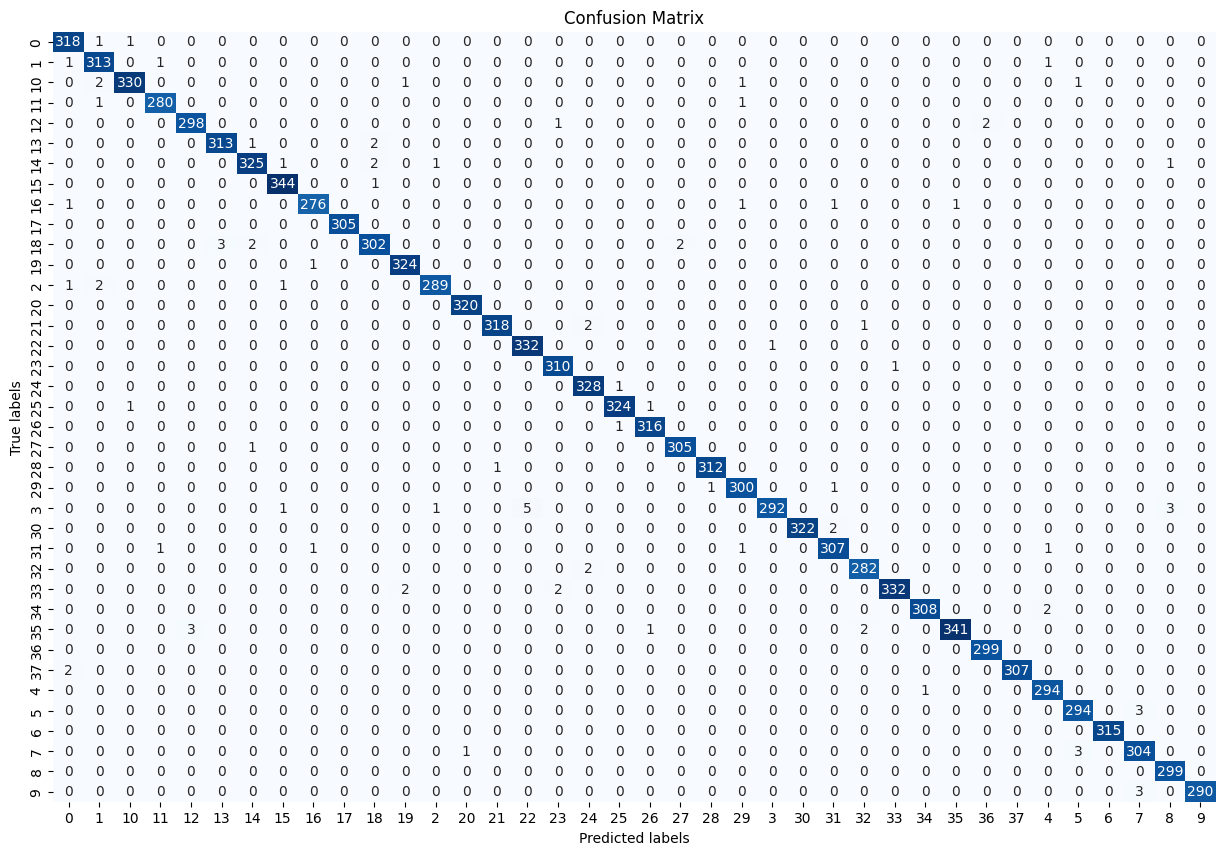

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming cm is your confusion matrix obtained from sklearn.metrics.confusion_matrix
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Assuming ensemble_predictions and test_generator.classes are correctly defined
# ensemble_predictions should be a numpy array of shape (num_samples, num_classes)
# test_generator.classes should be the true labels of the test set

# Generate classification report
report = classification_report(test_generator.classes, np.argmax(ensemble_predictions, axis=1),
                               target_names=test_generator.class_indices.keys())

print('Classification Report:')
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.98      0.99      0.99       316
          10       0.99      0.99      0.99       335
          11       0.99      0.99      0.99       282
          12       0.99      0.99      0.99       301
          13       0.99      0.99      0.99       316
          14       0.99      0.98      0.99       330
          15       0.99      1.00      0.99       345
          16       0.99      0.99      0.99       280
          17       1.00      1.00      1.00       305
          18       0.98      0.98      0.98       309
          19       0.99      1.00      0.99       325
           2       0.99      0.99      0.99       293
          20       1.00      1.00      1.00       320
          21       1.00      0.99      0.99       321
          22       0.99      1.00      0.99       333
          23       0.99      1.00      0.99       311
    

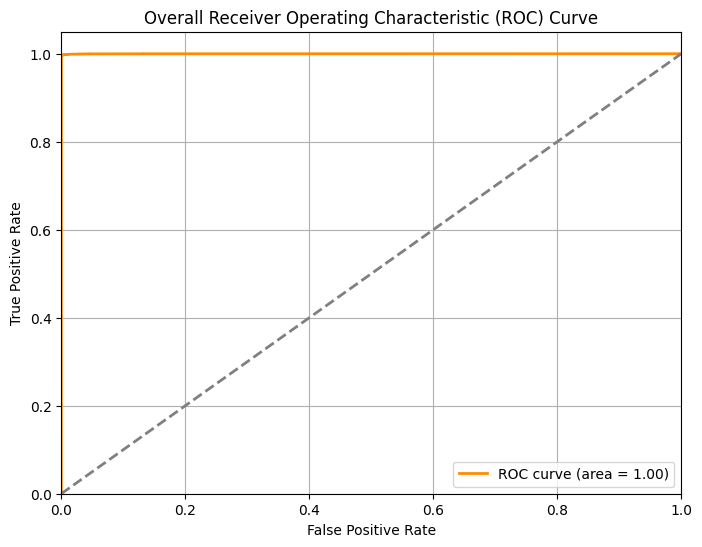

Overall ROC-AUC Score: 1.00


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

# Assuming ensemble_predictions and test_generator.classes are correctly defined
# ensemble_predictions should be a numpy array of shape (num_samples, num_classes)
# test_generator.classes should be the true labels of the test set

# Convert true labels to binary format
lb = LabelBinarizer()
true_labels = lb.fit_transform(test_generator.classes)

# Compute ROC curve for all classes combined
fpr, tpr, _ = roc_curve(true_labels.ravel(), ensemble_predictions.ravel())

# Calculate ROC-AUC score for all classes combined
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print ROC-AUC score
print(f'Overall ROC-AUC Score: {roc_auc:.2f}')